## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusion)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Stored in `df`.
a. Read in the dataset and take a look at the top few rows here:

In [3]:
df=pd.read_csv('ab_data.csv')

b. Use the cell below to find the number of rows in the dataset.

In [4]:
df.count()[0]

294478

c. The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [6]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
d1=df.query('group=="treatment"')
d2=df.query('landing_page=="new_page"')
unmatched_sum= d1.query('landing_page!="new_page"').count()[0]+d2.query('group!="treatment"').count()[0]

print('The number of times the new_page and treatment dont match.',unmatched_sum)

The number of times the new_page and treatment dont match. 3893


f. Do any of the rows have missing values?

In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.

a.Store my new dataframe in **df2**.

In [9]:
df2=df 
d1_to_drop=d1.query('landing_page!="new_page"')
d2_to_drop=d2.query('group!="treatment"')
df2.drop(d1_to_drop.index,inplace=True)
df2.drop(d2_to_drop.index,inplace=True)


In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [11]:
df2.count()[0]

290585

b. How many unique **user_id**s are in **df2**?

In [12]:
df2[df2.user_id.duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

c. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2[df2.user_id.duplicated()]


,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. What is the row information for the repeat **user_id**? 

In [14]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [15]:
df2.query('user_id=="773192"')
#we can see from below that:
#this user has visited the site again

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


e. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [16]:
df2.drop(df2[df2.user_id.duplicated()].index,inplace=True)
df2.user_id.duplicated().sum()

0


f. What is the probability of an individual converting regardless of the page they receive?

In [17]:
df2.converted.mean()

0.11959708724499628

g. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
df2.query('group=="control"').converted.mean()

0.1203863045004612

h. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
df2.query('group=="treatment"').converted.mean()

0.11880806551510564

k. What is the probability that an individual received the new page?

In [20]:
df2.query('landing_page=="new_page"').count()[0]/df2.count()[0]

0.50006194422266881

l. Considering results from parts (f) through (k) above, is this sufficient evidence to conclude that the new treatment page leads to more conversions.

**answer**

Although the old page shows a higher convertion rate, this result does not consider the significance of the results which can be missleading

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should our null and alternative hypotheses be?  we can state our hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**answer.**

$H_{0}$: **$p_{old}$** >= **$p_{new}$**

$H_{1}$: **$p_{old}$** < **$p_{new}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

let's use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

let's perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>



a. What is the **conversion rate** for $p_{new}$ under the null? 

In [21]:
# SINCE P HYPOTHESISED TO BE EQUALS TO CONVERTION RATE
df2.converted.mean()

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [22]:
# SINCE P HYPOTHESISED TO BE EQUALS TO CONVERTION RATE
df2.converted.mean()

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [23]:
n_new=df2.query('group=="treatment"').count()[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [24]:
n_old=df2.query('group=="control"').count()[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted=np.random.binomial(n_new,df2.converted.mean())
new_page_converted

17427

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted=np.random.binomial(n_old,df2.converted.mean())
old_page_converted

17372

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
diff=new_page_converted/n_new - old_page_converted/n_old
diff

0.00034887541481075368

h. Creating 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [28]:
p_diffs=list()
for i in range(int(1e4)): 
    p_new=np.random.binomial(n_new,df2.converted.mean())/n_new
    p_old=np.random.binomial(n_old,df2.converted.mean())/n_old
    diff= p_new-p_old
    p_diffs.append(diff)
p_diffs=np.array(p_diffs)

i. Plotting a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([  3.00000000e+00,   2.60000000e+01,   2.71000000e+02,
          1.08300000e+03,   2.60700000e+03,   3.22800000e+03,
          2.00700000e+03,   6.54000000e+02,   1.11000000e+02,
          1.00000000e+01]),
 array([-0.00532907, -0.00432284, -0.00331661, -0.00231038, -0.00130415,
        -0.00029791,  0.00070832,  0.00171455,  0.00272078,  0.00372702,
         0.00473325]),
 <a list of 10 Patch objects>)

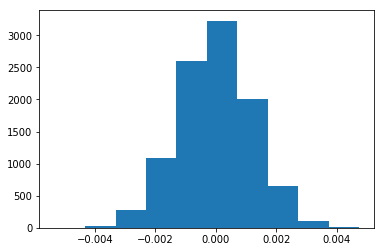

In [29]:
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [44]:
#calc the actual differences
old_mean=df2.query('group=="control"').converted.mean()
new_mean=df2.query('group=="treatment"').converted.mean()
diff= new_mean - old_mean
# calc proporion of the p_diffs > actual difference
(p_diffs>diff).mean()


0.90359999999999996

from the above we can say that the p-value kind of large we fails to reject the Null hypothesisand 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

convert_old = df2.query('landing_page=="old_page"').converted.sum()
convert_new = df2.query('landing_page=="new_page"').converted.sum()
n_old = df2.query('landing_page=="old_page"').count()[0]
n_new =  df2.query('landing_page=="new_page"').count()[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. using `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [32]:
z_score,p_value=sm.stats.proportions_ztest([convert_old,convert_new]
                                                      ,[n_old,n_new],alternative='smaller')
z_score,p_value





(1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Does it agree with the findings in parts **j.** and **k.**?

In [33]:
from scipy.stats import norm


In [34]:
norm.ppf(1-0.05)

1.6448536269514722


both P-value and z-score are used to ensure the significance of our result, as we know before that the p-value is probabilistice oriented and the z-score is speaking in terms of teh standard deviation . since our condifednce interval is 95 % as requested in the beggining of section II, 
therefore we can notice that z-score is less han 1.6448 (norm.ppf(1-0.05)) hence we fail to reject the null hypothesis which is consistent with the results we reported before.


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, We will see that the result that we have achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

Since each row is either a conversion or no conversion, We will use Logisitc Regression 

b. The goal is to use **statsmodels** to fit the regression model that we have specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, we first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  I will add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
df2['intercept']=1
df2[['control', 'treatment']] = pd.get_dummies(df2['group'])
df2.head(3)

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1


c. Using **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [36]:
logit = sm.Logit(df2['converted'],df2[['intercept','treatment']])

d. the summary of our model is as following

In [37]:
results = logit.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-08-21 00:31 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
treatment    -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  
What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**answer**

p-value is 0.1899, $H_{0}$ : $P_{new}$ =$P_{old}$ while  
$H_{1}$ : $P_{new}$ !=$P_{old}$
the difference is that in part II we perdormed a single-sided test, where here we performed a two-sided test

f. Now, we are considering other things that might influence whether or not an individual converts. is it a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**answer**
beacuse adding more factors increase our degree of freedom as it increase another factor with new coeffiecient that may contribute to more accurate results

g. Now along with testing if the conversion rate changes for different pages, I'll add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns -  We will need two columns for the three dummy variables. 

In [38]:
df_countries=pd.read_csv('countries.csv')
df3= df_countries.set_index('user_id').join(df2.set_index('user_id'),how='inner')

df3.head(3)

,country,timestamp,group,landing_page,converted,intercept,control,treatment
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1


h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  let's create the necessary additional columns, and fit the new model.  



In [39]:
## to make dummy variables let's see the values of country 
# in order to arrange the list on recieving the output of pd.get_dummies
df3.country.value_counts()


US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [40]:
df3[['CA','UK','US']] = pd.get_dummies(df3.country)
df3.head(4)

,country,timestamp,group,landing_page,converted,intercept,control,treatment,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0


In [47]:
# now let's create the model 
logit_mod=sm.Logit(df3.converted,df3[['intercept','treatment','CA','UK']])

In [48]:
result=logit_mod.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-08-21 00:34 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
treatment    -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

Hecne we can see that the contribution of the countries has no significant effects


In [49]:
# now let's get a higher order term by making relation between treatment and countries 
df3['CA_new'] = df3['CA'] * df3['treatment']
df3['UK_new'] = df3['UK'] * df3['treatment']


In [50]:
logit_mod=sm.Logit(df3.converted,df3[['intercept','treatment','CA','UK','CA_new','UK_new']])


In [52]:
results= logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-08-21 00:37 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
treatment    -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
CA_new       -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
UK_new        0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

The coeffiencts herer of all variables are nealy equal, however we can notice a better significance by looking at th P-vavlues than the previous model,
However the results are still not significant. 

### Conclusion <a id='conclusion'></a>

passing through all parts we,  Inpart I we found that the old page has higher rate of conversion however we were not sure of the significance of this result. So in Part II we started to test this hypothesis and we filed to reject the Null hypothesis which was the old page is better or at least was equal to the new one. In part III we saw another way for implementingthe A/B test by using the logisitc regression. 

### Final Word
Based on the upward analysis, I suggest the company to **restrict to the old page as the new page failed to do better conversion.**